## Imports

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import cross_val_score

## Functions

In [6]:
def extract_lbp_features(image):
    num_points = 24
    radius = 2
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Extrahiere die LBP-Merkmale aus dem Graustufenbild
    lbp = local_binary_pattern(gray_image, num_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hog_features = hog(gray_image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
    return hog_features

def predict_image_HOG(image, classifier):
    predict_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Verkleinere das Bild
    predict_resized_image = cv2.resize(predict_image, (300, 300))
    # Extrahiere die HOG-Merkmale
    hog_features = extract_hog_features(predict_resized_image)
    # Führe die Vorhersage mit dem Klassifikator durch
    prediction = classifier.predict([hog_features])[0]
    # Bestimme die Vertrauenswahrscheinlichkeit für die Vorhersage
    confidence = max(classifier.predict_proba([hog_features])[0])
    return prediction, confidence

def predict_image_LBP(image, classifier):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Verkleinere das Bild
    resized_image = cv2.resize(image, (300, 300))
    # Extrahiere die LBP-Merkmale
    lbp_features = extract_lbp_features(resized_image)
    # Führe die Vorhersage mit dem Klassifikator durch
    prediction = classifier.predict([lbp_features])[0]
    # Bestimme die Vertrauenswahrscheinlichkeit für die Vorhersage
    confidence = max(classifier.predict_proba([lbp_features])[0])
    return prediction, confidence
    
def detect_face(image_path):
    # Laden des Gesichtserkennungs-Klassifikators (Haar-Cascade)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # Laden des Bildes
    image = cv2.imread(image_path)
    if image is not None:
        # Konvertieren des Bildes in Graustufen
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Gesichter im Bild erkennen
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(300, 300))
        if len(faces) > 0:
            # Nehme das erste erkannte Gesicht
            (x, y, w, h) = faces[0]
            # Schneide das Gesicht aus
            face = image[y:y+h, x:x+w]
             # Zeichne ein Rechteck um das erkannte Gesicht
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
            return face
        else:
            print(f"No face detected in {image_path}")
            return None
    else:
        print(f"Failed to load image: {image_path}")
        return None

# Laden der Bilder und Extrahieren der Merkmale
def load_images_and_extract_features(data_folder, feature_extractor):
    features = []
    labels = []
    for folder_name in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, file_name)
                face = detect_face(image_path)
                if face is not None:
                    # Convert the image from BGR to RGB
                    rgb_face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                    resized_face = cv2.resize(rgb_face, (300, 300))
                    feature = feature_extractor(resized_face)
                    features.append(feature)
                    labels.append(folder_name)
                else:
                    print(f"Failed to detect face in image: {image_path}")
    return np.array(features), np.array(labels)

## Face detection auf zu trainierenden Bildern

In [7]:
#Pfad zum Ordner mit den Unterordnern für jede Person
base_path = "Bilder"

# Zielordner für die geschnittenen Gesichter
output_folder = 'Bilder_detected_faces'

# Erstellen des Zielordners, falls er noch nicht existiert
output_path = output_folder
os.makedirs(output_path, exist_ok=True)

# Durchlaufen der Ordner im Basispfad
for person_folder in os.listdir(base_path):
    person_folder_path = os.path.join(base_path, person_folder)
    # Überprüfen, ob es sich um einen Ordner handelt
    if os.path.isdir(person_folder_path):
        # Durchlaufen der Bilder im Unterordner
        for filename in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, filename)
            # Gesichtserkennung durchführen
            face = detect_face(image_path)
            if face is not None:
                # Pfad für das ausgeschnittene Gesicht
                new_folder_path = os.path.join(output_path, person_folder)
                os.makedirs(new_folder_path, exist_ok=True)
                new_image_path = os.path.join(new_folder_path, f"{filename.split('.')[0]}_face.jpg")
                # Speichern des ausgeschnittenen Gesichts als neues Bild
                cv2.imwrite(new_image_path, face)
                print(f"Gesicht in {filename} wurde erfolgreich ausgeschnitten und als {new_image_path} gespeichert.")
            else:
                print(f"Fehler beim Ausschneiden des Gesichts in {filename}.")

print("Gesichtserkennung und Ausschneiden abgeschlossen.")

Gesicht in WIN_20240402_16_36_01_Pro (2).jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro (2)_face.jpg gespeichert.
Gesicht in WIN_20240402_16_36_01_Pro (3).jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro (3)_face.jpg gespeichert.
Gesicht in WIN_20240402_16_36_01_Pro (4).jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro (4)_face.jpg gespeichert.
Gesicht in WIN_20240402_16_36_01_Pro (5).jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro (5)_face.jpg gespeichert.
Gesicht in WIN_20240402_16_36_01_Pro (6).jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro (6)_face.jpg gespeichert.
Gesicht in WIN_20240402_16_36_01_Pro.jpg wurde erfolgreich ausgeschnitten und als Bilder_detected_faces\Nino\WIN_20240402_16_36_01_Pro_face.jpg gespeichert.
Gesicht in WIN_202

## Erstelle Augmented Bilder

In [8]:
# Define the path to the dataset folder
data_folder = "Bilder_detected_faces"

# Liste zum Speichern der Bilder und ihrer Labels
augmented_images = []
augmented_labels = []

# Iterate over the folders in the dataset folder
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    # Check if the item is a folder
    if os.path.isdir(folder_path):
        # Iterate over the files in the folder
        for file_name in os.listdir(folder_path):
            # Assuming the files are image files, you can adjust the file type according to your dataset
            # Read the image using OpenCV
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(folder_path, file_name)
                image = cv2.imread(image_path)
                # Check if the image is loaded successfully
                if image is not None:
                    # Convert the image from BGR to RGB
                    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # Resize the image to a desired size
                    resized_image = cv2.resize(rgb_image, (300, 300))
                    # Perform image augmentation using Keras ImageDataGenerator
                    datagen = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode='constant'
                    )
                    # Reshape the image to add batch dimension
                    reshaped_image = resized_image.reshape((1,) + resized_image.shape)
                    # Generate augmented images and append to the list
                    i = 0
                    for batch in datagen.flow(reshaped_image, batch_size=1):
                        augmented_image = batch[0].astype(np.uint8)
                        augmented_images.append(augmented_image)
                        augmented_labels.append(folder_name)  # Hinzufügen des Labels (Ordnername)
                        i += 1
                        if i >= 80:
                            break  # Break the loop after generating 100 augmented images
                else:
                    print(f"Failed to load image: {image_path}")
            else:
                print(f"Skipping non-image file: {file_name}")

# Ausgabe der Anzahl der geladenen Bilder
print(f"Total images: {len(augmented_images)}")
print(f"Total labels: {len(augmented_labels)}")

Total images: 6720
Total labels: 6720


## Hog Training Feature Extraction

In [9]:
# Initialize empty lists to store HOG features and labels
hog_features = []
hog_labels = []

# Iterate over the images and labels in the lists
for image, label in zip(augmented_images, augmented_labels):
    hog_feature = extract_hog_features(image)
    # Add the HOG feature to the list of features
    hog_features.append(hog_feature)
    # Add the label to the list of labels
    hog_labels.append(label)
    # Print HOG features and label
    print(f"HOG features: {hog_feature}, Label: {label}")

print(f"Total HOG features: {len(hog_features)}")
print(f"Total labels: {len(hog_labels)}")

HOG features: [0.02092751 0.00925578 0.10681381 ... 0.         0.         0.        ], Label: Nino
HOG features: [0. 0. 0. ... 0. 0. 0.], Label: Nino
HOG features: [0.         0.         0.         ... 0.01389447 0.05630318 0.07344427], Label: Nino
HOG features: [0.         0.         0.         ... 0.13761029 0.12813007 0.02538814], Label: Nino
HOG features: [0.38105505 0.38105505 0.38105505 ... 0.         0.         0.        ], Label: Nino
HOG features: [0. 0. 0. ... 0. 0. 0.], Label: Nino
HOG features: [0. 0. 0. ... 0. 0. 0.], Label: Nino
HOG features: [0.2205684  0.110632   0.19551114 ... 0.         0.         0.        ], Label: Nino
HOG features: [0.         0.         0.         ... 0.00499202 0.10603982 0.38454457], Label: Nino
HOG features: [0.         0.         0.         ... 0.04117999 0.06129007 0.13492256], Label: Nino
HOG features: [0. 0. 0. ... 0. 0. 0.], Label: Nino
HOG features: [0.         0.         0.         ... 0.00865312 0.01489537 0.0808165 ], Label: Nino
HOG 

## LBP Training Feature Extraction

In [10]:
# Initialize empty lists to store LBP features
lbp_features = []
lbp_labels = []

# Parameter für LBP festlegen
num_points = 24
radius = 2

# Iterate over the images and labels in the lists
for image, label in zip(augmented_images, augmented_labels):
    # Extract LBP features
    lbp_feature = extract_lbp_features(image)
    # Flatten the LBP feature array and append to the list of features
    lbp_features.append(lbp_feature)
    # Add the label to the list of labels
    lbp_labels.append(label)
    # Print LBP features and label
    print(f"LBP features: {lbp_feature}, Label: {label}")

print(f"Total LBP features: {len(lbp_features)}")
print(f"Total labels: {len(lbp_labels)}")

LBP features: [0.01807778 0.01224444 0.00396667 0.00954444 0.00718889 0.01058889
 0.00978889 0.01584444 0.01733333 0.02791111 0.03765556 0.0714
 0.07871111 0.07351111 0.04413333 0.03267778 0.0214     0.01945556
 0.01277778 0.01455556 0.01051111 0.01257778 0.00931111 0.0065
 0.26058889 0.16174444], Label: Nino
LBP features: [0.02007778 0.014      0.00414444 0.01117778 0.00827778 0.01222222
 0.01153333 0.01857778 0.02085556 0.03267778 0.04294444 0.07328889
 0.09642222 0.08188889 0.04893333 0.04033333 0.02442222 0.02272222
 0.01527778 0.01681111 0.01248889 0.0149     0.01068889 0.00821111
 0.15277778 0.18434444], Label: Nino
LBP features: [0.01684444 0.01308889 0.00314444 0.01025556 0.00695556 0.01094444
 0.01048889 0.01845556 0.01977778 0.03193333 0.04252222 0.0694
 0.09801111 0.08437778 0.04983333 0.03958889 0.02397778 0.0223
 0.01443333 0.01706667 0.01142222 0.01324444 0.00963333 0.00678889
 0.19725556 0.15825556], Label: Nino
LBP features: [0.01836667 0.01394444 0.00473333 0.01027778 

## Random Forest

In [11]:
## lbp Random Forest
# Laden der Trainingsdaten für LBP
X_train_lbp = lbp_features
y_train_lbp = lbp_labels

# Laden der Testdaten für LBP
X_test_lbp, y_test_lbp = load_images_and_extract_features("Test", lambda img: extract_lbp_features(img))

# Initialisierung des Random-Forest-Klassifikators
rf_classifier_lbp = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, verbose=0 , max_depth=5, criterion='gini')
 
# Durchführung der Kreuzvalidierung mit 5 Faltungen
cv_scores_lbp = cross_val_score(rf_classifier_lbp, X_train_lbp, y_train_lbp, cv=5)

# Trainieren des Random-Forest-Modells auf dem gesamten Trainingsdatensatz
rf_classifier_lbp.fit(X_train_lbp, y_train_lbp)
 
# Evaluierung des Modells auf den Testdaten für LBP
accuracy_lbp = rf_classifier_lbp.score(X_test_lbp, y_test_lbp)
predicted_lbp = rf_classifier_lbp.predict(X_test_lbp)

# Ausgabe der Ergebnisse
print("Cross-Validation Scores lbp:", cv_scores_lbp)
print("Mean Accuracy (Cross-Validation) lbp:", cv_scores_lbp.mean())
print("Accuracy (Test Set) lbp:", accuracy_lbp)
print("Predicted (Test Set) lbp:", predicted_lbp)


## HOG Randon Forest
X_train_hog = hog_features
y_train_hog = hog_labels

# Laden der Testdaten für HOG
X_test_hog, y_test_hog = load_images_and_extract_features("Test", lambda img: extract_hog_features(img))

# Initialisierung des Random-Forest-Klassifikators
rf_classifier_hog = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, verbose=0, max_depth=5, max_features='sqrt', criterion='gini')

# Durchführung der Kreuzvalidierung mit 5 Faltungen
cv_scores = cross_val_score(rf_classifier_hog, X_train_hog, y_train_hog, cv=5)

# Trainieren des Random-Forest-Modells auf dem gesamten Trainingsdatensatz
rf_classifier_hog.fit(X_train_hog, y_train_hog)

# Evaluierung des Modells auf den Testdaten (optional)
accuracy_hog = rf_classifier_hog.score(X_test_hog, y_test_hog)
predicted_hog = rf_classifier_hog.predict(X_test_hog)

# Ausgabe der Ergebnisse
print("Cross-Validation Scores hog:", cv_scores)
print("Mean Accuracy (Cross-Validation) hog:", cv_scores.mean())
print("Accuracy (Test Set) hog:", accuracy_hog)
print("Predicted (Test Set) hog:", predicted_hog)

Cross-Validation Scores lbp: [0.83035714 0.83556548 0.86979167 0.82738095 0.84747024]
Mean Accuracy (Cross-Validation) lbp: 0.8421130952380953
Accuracy (Test Set) lbp: 0.5
Predicted (Test Set) lbp: ['Robin' 'Robin' 'Robin' 'Robin' 'Robin' 'Robin' 'Robin' 'Robin' 'Robin'
 'Robin' 'Robin' 'Robin' 'Robin' 'Robin' 'Robin' 'Robin']
Cross-Validation Scores hog: [0.828125   0.828125   0.90401786 0.85565476 0.8139881 ]
Mean Accuracy (Cross-Validation) hog: 0.8459821428571429
Accuracy (Test Set) hog: 1.0
Predicted (Test Set) hog: ['Nino' 'Nino' 'Nino' 'Nino' 'Nino' 'Nino' 'Nino' 'Nino' 'Robin' 'Robin'
 'Robin' 'Robin' 'Robin' 'Robin' 'Robin' 'Robin']


## Bilder predicten

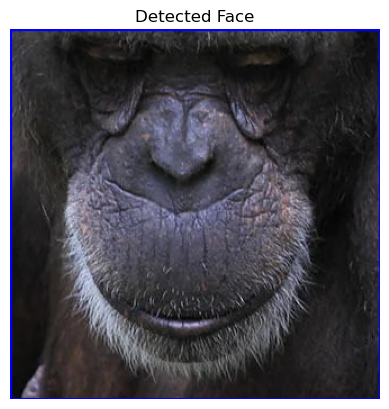

Prediction LBP for 2010-06-14-Affen-Zoo-Hannover-7047-c-PETA-D.png: Robin, Confidence: 0.9306223180430222
Prediction HOG for 2010-06-14-Affen-Zoo-Hannover-7047-c-PETA-D.png: Robin, Confidence: 0.7174377350946523


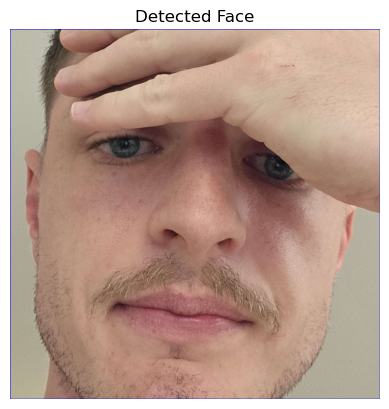

Prediction LBP for 20240326_154707.jpg: Robin, Confidence: 0.9289290652076695
Prediction HOG for 20240326_154707.jpg: Robin, Confidence: 0.7391722154954671


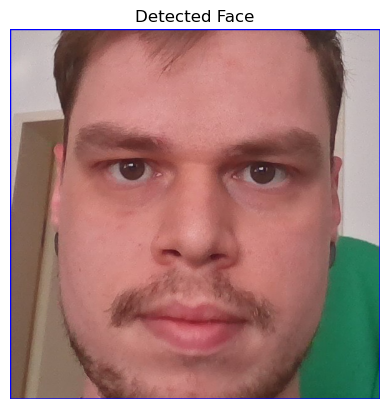

Prediction LBP for image (2).jpg: Robin, Confidence: 0.9274615799622742
Prediction HOG for image (2).jpg: Robin, Confidence: 0.6515743972437056


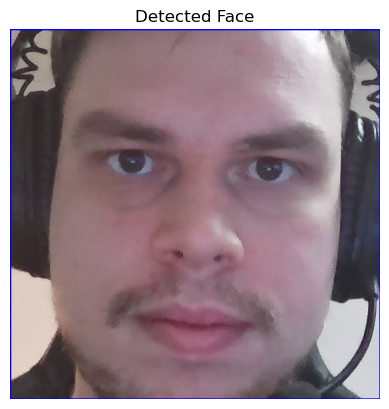

Prediction LBP for image (3).jpg: Robin, Confidence: 0.8381111297384951
Prediction HOG for image (3).jpg: Robin, Confidence: 0.5977520790475603


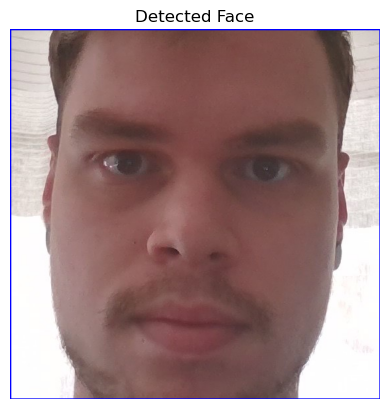

Prediction LBP for image (4).jpg: Robin, Confidence: 0.9412125945930001
Prediction HOG for image (4).jpg: Robin, Confidence: 0.7203760589393261


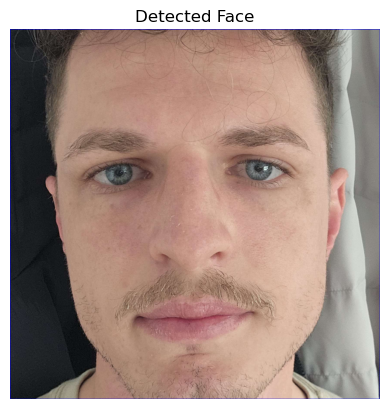

Prediction LBP for robin191.jpg: Robin, Confidence: 0.926537287117409
Prediction HOG for robin191.jpg: Robin, Confidence: 0.7385072254894633


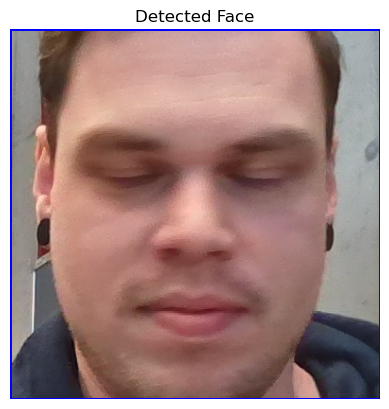

Prediction LBP for WIN_20240402_16_36_01_Pro (3).jpg: Robin, Confidence: 0.6874997976694186
Prediction HOG for WIN_20240402_16_36_01_Pro (3).jpg: Nino, Confidence: 0.6625419657224598


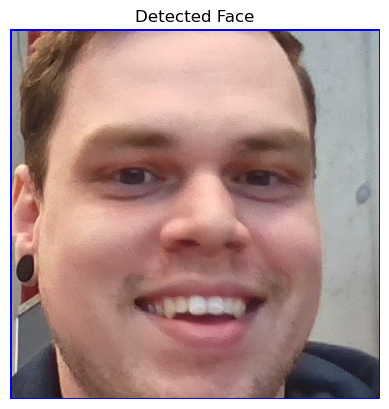

Prediction LBP for WIN_20240402_16_36_04_Pro (5).jpg: Robin, Confidence: 0.6546227269273878
Prediction HOG for WIN_20240402_16_36_04_Pro (5).jpg: Nino, Confidence: 0.6858609483392346


In [14]:
# Ordnerpfad mit den zu klassifizierenden Bildern
predict_folder = "predict"

# Iteriere über die Bilder im Ordner und führe die Vorhersage durch
for filename in os.listdir(predict_folder):
    image_path = os.path.join(predict_folder, filename)
    # Gesichtserkennung durchführen
    face = detect_face(image_path)
    if face is not None:
        # Plotte das Originalbild mit dem markierten Gesicht
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Detected Face')
        plt.show()
        # Vorhersage mit LBP durchführen
        prediction, confidence = predict_image_LBP(face, rf_classifier_lbp)
        if prediction is not None:
            print(f"Prediction LBP for {filename}: {prediction}, Confidence: {confidence}")
        # Vorhersage mit HOG durchführen
        prediction, confidence = predict_image_HOG(face, rf_classifier_hog)
        if prediction is not None:
            print(f"Prediction HOG for {filename}: {prediction}, Confidence: {confidence}")
    else:
        print(f"Failed to detect face in {filename}")